# Classification with XGBoost

---

## 1. Load Tensors and Targets

The training, validation and test tensors along with the associated targets are loaded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common import *

%matplotlib inline

bottleneck_features = np.load('data/bottleneck_features/yelp_resnet50.npz')

X_train = bottleneck_features['train_features'].reshape(20000,2048)
X_valid = bottleneck_features['valid_features'].reshape(2000,2048)
X_test  = bottleneck_features['test_features'].reshape(2000,2048)

y_train = bottleneck_features['train_targets']
y_valid = bottleneck_features['valid_targets']
y_test  = bottleneck_features['test_targets']

Using TensorFlow backend.


## 2. Features scaling

The features are standardized by removing the mean and scaling to unit variance. The scaler is first derived on the training data and then applied on the training, validation and test data. 

In [2]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

del X_train, X_valid, X_test

## 3. Principal Component Analysis

A principal component analysis (PCA) is carried out in order reduce the number of bottleneck features. The plot below shows that the first 200 principal components capture about 70% of the variance in the training data. Not that this transformationallows to reduce the number of features from 2048 to 200, roughly one order of magnitude.

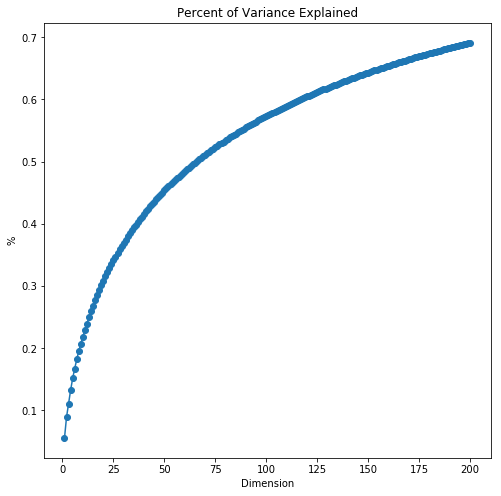

In [3]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True)
pca.fit(X_train_scaled)

X_train_reduced = pca.transform(X_train_scaled)
X_valid_reduced = pca.transform(X_valid_scaled)
X_test_reduced = pca.transform(X_test_scaled)

del X_train_scaled, X_valid_scaled, X_test_scaled

plt.figure(figsize=(8,8))
plt.plot(np.arange(1, n_comp+1), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('Dimension')
plt.ylabel('%')
plt.title("Percent of Variance Explained")
plt.show()

The scatter matrix of the first 10 principal components is shown below. As expected by construction, one can see that the principal components are uncorrelated.

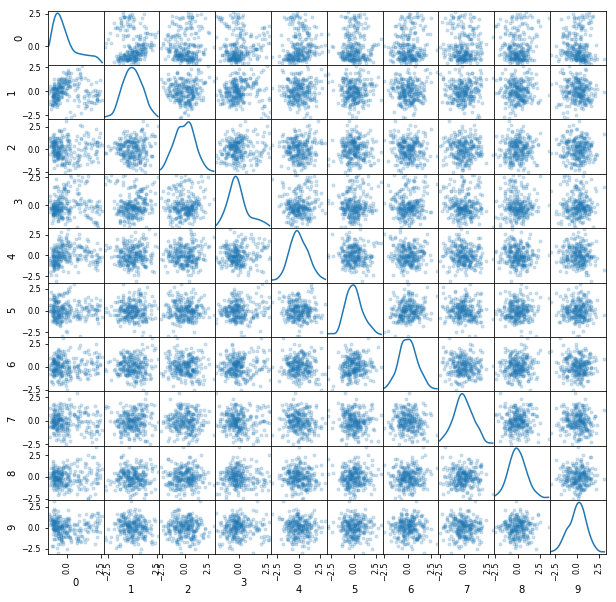

In [4]:
data = pd.DataFrame(X_train_reduced)

from pandas.tools.plotting import scatter_matrix
corr = scatter_matrix(data.iloc[:250,:10], alpha=0.2, figsize=(10, 10), diagonal='kde')

## 4. Classification with XGBoost

The XGBoost model is used for the classification. The logarithmic of the loss function is used as evaluation metric during the training.

### A. Independent case

We fit an independent XGBoost model for each class. The minimization is controlled by the validation data. If the value of the logarithmic loss function calculated on the validation does not improve over ten consecutive epochs then the training is stopped.

#### $\alpha$- Training

[0]	train-logloss:0.687208	valid-logloss:0.688253
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.548643	valid-logloss:0.57827
[60]	train-logloss:0.464521	valid-logloss:0.522269
[90]	train-logloss:0.406348	valid-logloss:0.491805
[120]	train-logloss:0.360431	valid-logloss:0.473064
[150]	train-logloss:0.323489	valid-logloss:0.461198
[180]	train-logloss:0.293013	valid-logloss:0.453096
[210]	train-logloss:0.267278	valid-logloss:0.446115
[240]	train-logloss:0.245659	valid-logloss:0.44205
[270]	train-logloss:0.226704	valid-logloss:0.439004
[300]	train-logloss:0.209949	valid-logloss:0.436714
[330]	train-logloss:0.194852	valid-logloss:0.435018
[360]	train-logloss:0.181331	valid-logloss:0.433265
[390]	train-logloss:0.168663	valid-logloss:0.432142
Stopping. Best iteration:
[391]	train-logloss:0.168305	valid-logloss:0.432029



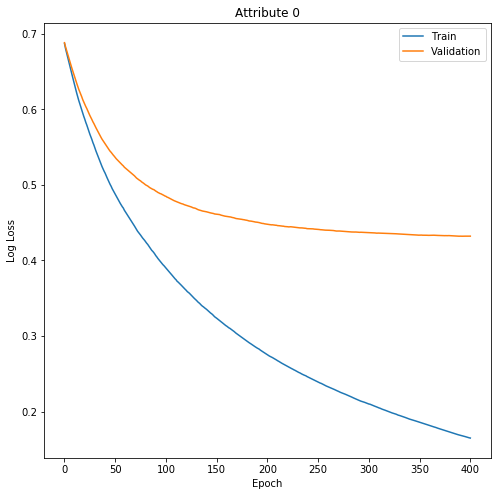

[0]	train-logloss:0.690435	valid-logloss:0.691865
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.598437	valid-logloss:0.647003
[60]	train-logloss:0.528735	valid-logloss:0.617459
[90]	train-logloss:0.475023	valid-logloss:0.599784
[120]	train-logloss:0.429963	valid-logloss:0.586172
[150]	train-logloss:0.389613	valid-logloss:0.572998
[180]	train-logloss:0.355355	valid-logloss:0.563408
[210]	train-logloss:0.325586	valid-logloss:0.554684
[240]	train-logloss:0.301218	valid-logloss:0.548685
[270]	train-logloss:0.278851	valid-logloss:0.544568
[300]	train-logloss:0.260015	valid-logloss:0.541134
[330]	train-logloss:0.242641	valid-logloss:0.537328
[360]	train-logloss:0.225721	valid-logloss:0.534614
[390]	train-logloss:0.21104	valid-logloss:0.532768
Stopping. Best iteration:
[399]	train-logloss:0.206892	valid-logloss:0.531903



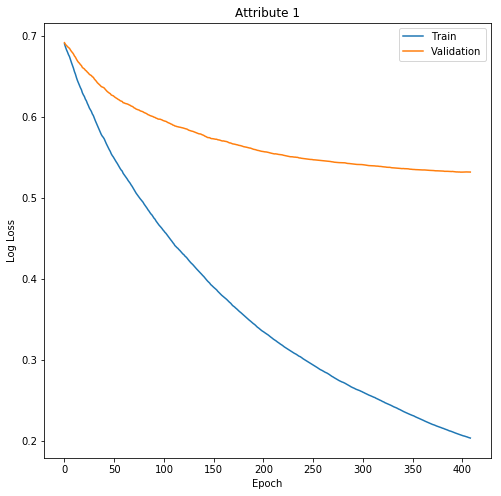

[0]	train-logloss:0.689561	valid-logloss:0.691496
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.583263	valid-logloss:0.630828
[60]	train-logloss:0.505978	valid-logloss:0.59112
[90]	train-logloss:0.449074	valid-logloss:0.568926
[120]	train-logloss:0.402434	valid-logloss:0.551485
[150]	train-logloss:0.361378	valid-logloss:0.53643
[180]	train-logloss:0.328264	valid-logloss:0.526363
[210]	train-logloss:0.29837	valid-logloss:0.516522
[240]	train-logloss:0.273996	valid-logloss:0.510831
[270]	train-logloss:0.252212	valid-logloss:0.505882
[300]	train-logloss:0.232528	valid-logloss:0.500887
[330]	train-logloss:0.215111	valid-logloss:0.497105
[360]	train-logloss:0.19934	valid-logloss:0.493831
[390]	train-logloss:0.186084	valid-logloss:0.491118
[420]	train-logloss:0.173848	valid-logloss:0.488647
[450]	train-logloss:0.162309	valid-logloss:0.485928
[480]	train-logloss:0.1518

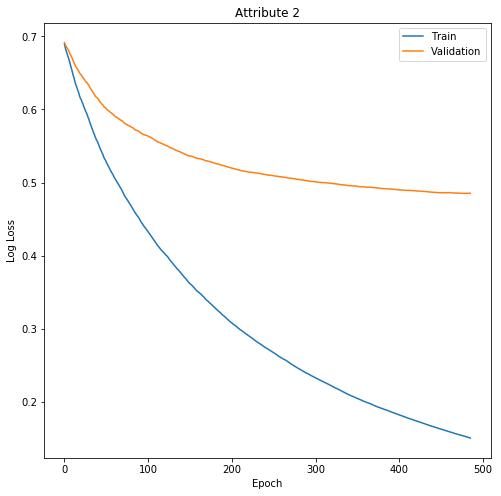

[0]	train-logloss:0.691702	valid-logloss:0.692967
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.641386	valid-logloss:0.687245
[60]	train-logloss:0.601698	valid-logloss:0.683476
[90]	train-logloss:0.564151	valid-logloss:0.681122
[120]	train-logloss:0.530496	valid-logloss:0.677986
Stopping. Best iteration:
[133]	train-logloss:0.516065	valid-logloss:0.676798



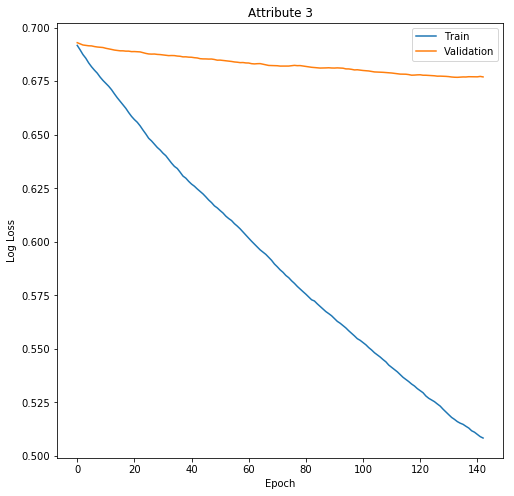

[0]	train-logloss:0.690666	valid-logloss:0.692201
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.597296	valid-logloss:0.653401
[60]	train-logloss:0.528005	valid-logloss:0.626528
[90]	train-logloss:0.474863	valid-logloss:0.611484
[120]	train-logloss:0.429029	valid-logloss:0.598368
[150]	train-logloss:0.389958	valid-logloss:0.586175
[180]	train-logloss:0.356062	valid-logloss:0.57695
[210]	train-logloss:0.327307	valid-logloss:0.57056
[240]	train-logloss:0.302471	valid-logloss:0.565717
[270]	train-logloss:0.280258	valid-logloss:0.561219
[300]	train-logloss:0.259816	valid-logloss:0.558079
[330]	train-logloss:0.241621	valid-logloss:0.556418
[360]	train-logloss:0.224366	valid-logloss:0.554043
[390]	train-logloss:0.210004	valid-logloss:0.551788
[420]	train-logloss:0.197006	valid-logloss:0.550286
[450]	train-logloss:0.184779	valid-logloss:0.549159
[480]	train-logloss:0.17

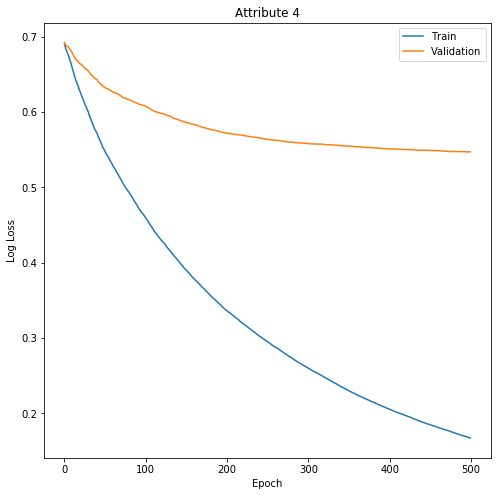

[0]	train-logloss:0.688059	valid-logloss:0.689359
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.558244	valid-logloss:0.594158
[60]	train-logloss:0.474006	valid-logloss:0.541754
[90]	train-logloss:0.414804	valid-logloss:0.513053
[120]	train-logloss:0.367846	valid-logloss:0.494254
[150]	train-logloss:0.328858	valid-logloss:0.479064
[180]	train-logloss:0.295659	valid-logloss:0.467886
[210]	train-logloss:0.267844	valid-logloss:0.458489
[240]	train-logloss:0.244651	valid-logloss:0.451828
[270]	train-logloss:0.224763	valid-logloss:0.447531
[300]	train-logloss:0.206714	valid-logloss:0.443739
[330]	train-logloss:0.190473	valid-logloss:0.440342
[360]	train-logloss:0.17571	valid-logloss:0.437078
[390]	train-logloss:0.163472	valid-logloss:0.434757
[420]	train-logloss:0.1521	valid-logloss:0.432622
[450]	train-logloss:0.142332	valid-logloss:0.431281
[480]	train-logloss:0.133

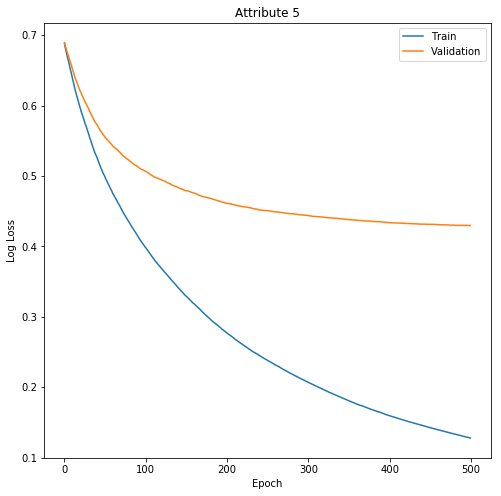

[0]	train-logloss:0.68722	valid-logloss:0.688121
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.53981	valid-logloss:0.567643
[60]	train-logloss:0.447488	valid-logloss:0.503227
[90]	train-logloss:0.384799	valid-logloss:0.46816
[120]	train-logloss:0.337149	valid-logloss:0.444872
[150]	train-logloss:0.298535	valid-logloss:0.429142
[180]	train-logloss:0.266038	valid-logloss:0.417071
[210]	train-logloss:0.238965	valid-logloss:0.408127
[240]	train-logloss:0.217201	valid-logloss:0.402532
[270]	train-logloss:0.198301	valid-logloss:0.397821
[300]	train-logloss:0.180847	valid-logloss:0.393997
[330]	train-logloss:0.165809	valid-logloss:0.391372
[360]	train-logloss:0.152424	valid-logloss:0.389065
[390]	train-logloss:0.140538	valid-logloss:0.38744
[420]	train-logloss:0.130095	valid-logloss:0.385999
[450]	train-logloss:0.120558	valid-logloss:0.384368
[480]	train-logloss:0.1118

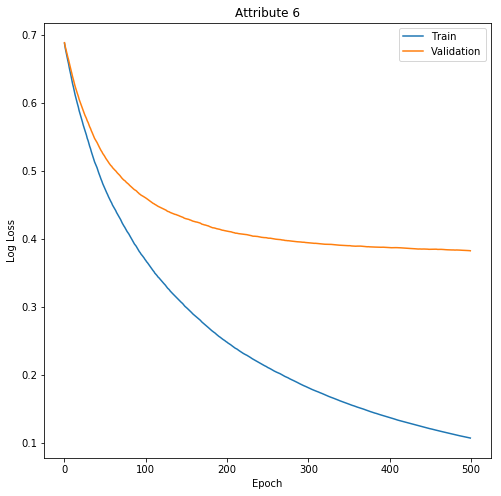

[0]	train-logloss:0.690219	valid-logloss:0.691939
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.596147	valid-logloss:0.644992
[60]	train-logloss:0.527326	valid-logloss:0.61635
[90]	train-logloss:0.475261	valid-logloss:0.598327
[120]	train-logloss:0.431578	valid-logloss:0.585249
[150]	train-logloss:0.392854	valid-logloss:0.57402
[180]	train-logloss:0.359125	valid-logloss:0.56528
[210]	train-logloss:0.330253	valid-logloss:0.557842
[240]	train-logloss:0.305829	valid-logloss:0.552558
[270]	train-logloss:0.284619	valid-logloss:0.548286
[300]	train-logloss:0.265438	valid-logloss:0.544587
[330]	train-logloss:0.24819	valid-logloss:0.541271
[360]	train-logloss:0.231466	valid-logloss:0.539358
[390]	train-logloss:0.216751	valid-logloss:0.538149
[420]	train-logloss:0.204167	valid-logloss:0.537099
[450]	train-logloss:0.19183	valid-logloss:0.535805
[480]	train-logloss:0.18081

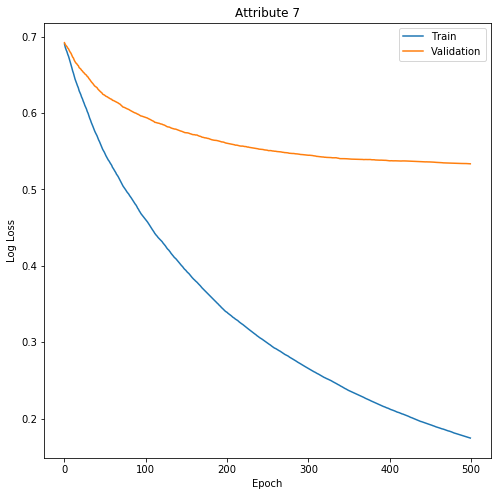

[0]	train-logloss:0.6904	valid-logloss:0.692555
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.601124	valid-logloss:0.655649
[60]	train-logloss:0.530969	valid-logloss:0.629194
[90]	train-logloss:0.477019	valid-logloss:0.613525
[120]	train-logloss:0.431312	valid-logloss:0.600278
[150]	train-logloss:0.391154	valid-logloss:0.588593
[180]	train-logloss:0.356991	valid-logloss:0.580391
[210]	train-logloss:0.327853	valid-logloss:0.57404
[240]	train-logloss:0.30202	valid-logloss:0.568003
[270]	train-logloss:0.279535	valid-logloss:0.563919
[300]	train-logloss:0.25884	valid-logloss:0.560951
[330]	train-logloss:0.241345	valid-logloss:0.557909
[360]	train-logloss:0.224298	valid-logloss:0.555029
[390]	train-logloss:0.209651	valid-logloss:0.553141
[420]	train-logloss:0.196951	valid-logloss:0.551657
[450]	train-logloss:0.184887	valid-logloss:0.549989
[480]	train-logloss:0.17363

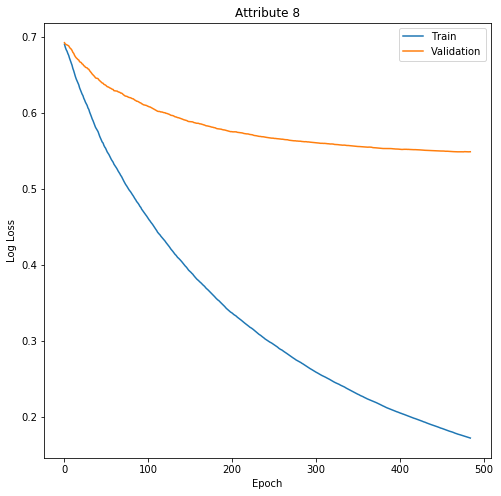

In [5]:
import xgboost as xgb

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.015
param['max_depth'] = 10
param['subsample'] = 0.5
param['eval_metric'] = 'logloss'
param['colsample_bytree'] = 0.3
param['nthread'] = 4

num_round = 500

y_test_ovr = np.zeros(y_test.shape, dtype=np.float32)

for i in range(9):
    xg_train = xgb.DMatrix(X_train_reduced, label=y_train[:,i])
    xg_valid = xgb.DMatrix(X_valid_reduced, label=y_valid[:,i])
    xg_test = xgb.DMatrix(X_test_reduced, label=y_test[:,i])

    eval_list = [(xg_train, 'train'),(xg_valid, 'valid')]
    results = {}
    model = xgb.train(param, xg_train, num_round, eval_list, verbose_eval=30, 
                      early_stopping_rounds=10, evals_result=results)

    y_test_ovr[:,i] = model.predict(xg_test)
    
    epochs = len(results['train']['logloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(8,8))
    plt.ylabel('Log Loss')
    plt.xlabel('Epoch')
    plt.title('Attribute %d' %i)
    plt.plot(x_axis, results['train']['logloss'], label='Train')
    plt.plot(x_axis, results['valid']['logloss'], label='Validation')
    plt.legend()
    plt.show()
    
del xg_train, xg_valid, xg_test

#### $\beta$- $F_1$ score

The $F_1$ score is derived on the test dataset.

In [6]:
f1_score_ovr = f1_score(y_test, (y_test_ovr >=0.5).astype(int))
print("F1 score = %.5f" % f1_score_ovr)

F1 score = 0.75027


### B. Classifier Chain

The correlation among classes can be exploited usin [classifier chains](https://en.wikipedia.org/wiki/Classifier_chains).

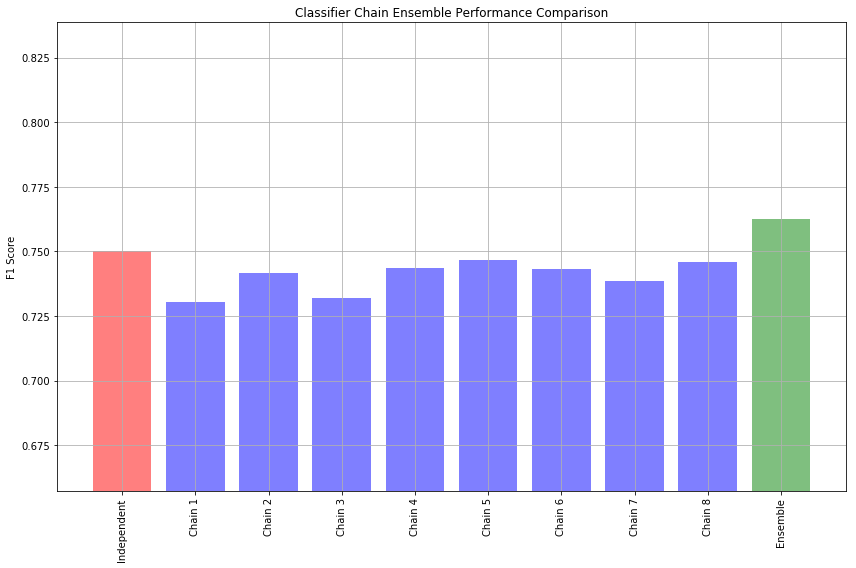

In [7]:
from xgboost import XGBClassifier
from sklearn.multioutput import ClassifierChain

n_chains = 8
chains = [ClassifierChain(XGBClassifier(n_estimators=500, objective='binary:logistic', eta=0.015, 
                                        max_depth=10, subsample=0.5, eval_metric='logloss', 
                                        colsample_bytree=0.3, nthread=4), 
                          order='random', random_state=i) for i in range(n_chains)]

f1_score_chains = []
y_test_chains = np.array([[0]*9]*len(y_test), dtype=np.float32)
for chain in chains: 
    chain.fit(X_train_reduced, y_train)
    y_test_chain = chain.predict_proba(X_test_reduced)
    f1_score_chains.append(f1_score(y_test,(y_test_chain >= 0.5).astype(int)))
    y_test_chains = y_test_chains + y_test_chain

y_test_ensemble = y_test_chains/n_chains
f1_score_ensemble = f1_score(y_test, y_test_ensemble >= 0.5)

f1_score_models = [f1_score_ovr] + f1_score_chains
f1_score_models.append(f1_score_ensemble)

name_models = ['Chain ' + str(i) for i in range(1,n_chains+1)]
name_models.insert(0,'Independent')
name_models.append('Ensemble')

x_pos = np.arange(len(name_models))

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(name_models, rotation='vertical')
ax.set_ylabel('F1 Score')
ax.set_ylim([min(f1_score_models) * .9, max(f1_score_models) * 1.1])
colors = ['r'] + ['b'] * len(f1_score_chains) + ['g']
ax.bar(x_pos, f1_score_models, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [8]:
print("F1 score = %.5f" % f1_score_ensemble)

F1 score = 0.76238
